In [1]:
year = None
month = None
program = "prepilot"
include_replaced_modes_as_valid = True # Flip this when we want to get results versus generate the replaced_mode correction graphs
input_dataset = "ONLY_LABELED" # "ONLY_LABELED", "ONLY_SENSED" or "BEST_AVAILABLE" for sensitivity analysis
LABEL_ASSIST_THRESHOLD = 0.3

In [2]:
from collections import defaultdict
import datetime

import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.distributions as dist
from biogeme.expressions import Beta, DefineVariable, RandomVariable, bioDraws, log, MonteCarlo, Integrate
import biogeme.results as res
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import sklearn.metrics
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import emission.core.get_database as edb
import emission.core.wrapper.entry as ecwe
import emission.storage.decorations.analysis_timeseries_queries as esda
import emission.storage.decorations.trip_queries as esdt
import emission.storage.decorations.timeline as esdl
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import scaffolding
from uuid import UUID

%matplotlib inline

Connecting to database URL db


## Collect Data From Database

In [3]:
# Loading mapping dictionaries from mapping_dictionaries notebook
# Dictionary map is putting all other replaced modes into other
%store -r df_EI
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_re = defaultdict(lambda: 'Other',dic_re)

In [4]:
tq = scaffolding.get_time_query(year, month)

In [5]:
# Let's get UUID lists for all the three categories
# stage, all, non_stage
stage_uuids = []
all_uuids = []
non_stage_uuids = []
for ue in edb.get_uuid_db().find():
    all_uuids.append(str(ue['uuid']))
    if ue['user_email'].startswith("stage_"):
        stage_uuids.append(str(ue['uuid']))
    else:
        non_stage_uuids.append(str(ue['uuid']))
stage_uuids

['2bc8ca71-7d0f-4930-ba2c-cf97f7dceaea',
 'b0c98c51-4bb9-4c67-9ec3-7814cfbdfc82',
 'd4376620-fbcd-4aab-95bf-8c2e0ecf9adf',
 '802667b6-371f-45b2-9c7a-bb051244836a',
 '1fdbfb17-5168-445a-8c2b-14efd528ccdd',
 'cc46e76f-10a1-4376-8548-0b909b290ba0',
 'edf65849-3a6e-406a-8e4e-19044ab01ba5',
 '6373dfb8-cb9b-47e8-8e8f-76adcfadde20',
 '93c6e0f1-56a4-4e07-b920-ded664419dc6',
 'e89976df-90c0-4e04-87bf-f81ccd2e36d4',
 '73c7bf7e-2552-4a6d-b211-62190d2322e2',
 '29d04974-ff70-4c61-a0b0-dafcc1d23ec8',
 '0118ea1d-1a13-4e61-b99a-d68ac08e883f',
 '87cb8852-9b61-4c0e-91ec-07a33145659b',
 '656d997c-5122-4526-9874-9949b1f50fe5',
 'ce0f2630-4819-4bca-afa3-291b9f25da93',
 'd22cd8f0-1857-4796-ab27-6aa59cd1e1b3',
 'ae91f6bc-b25d-4d80-93ba-0159ac220901',
 'c49a0a47-6bfa-4fa1-94c9-b850c97dbfb4',
 '1ac2dbad-b3cb-4597-89af-f4de4340b5f0',
 '9aa33ec1-c02d-437d-9b65-389e20beaa00',
 '7ac4a17a-985f-46b4-9114-c139305aae29',
 '5f0ceaa8-d604-426b-b9a9-49629d6a085f',
 '659974c8-053a-48ba-a6c6-a3cc4fa31004',
 '37ae3762-24e7-

In [6]:
# Here are the proportions across them
len(stage_uuids), len(non_stage_uuids), len(all_uuids)

(82, 131, 213)

In [7]:
# Load all the participant confirmed trips
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)

[UUID('863e9c6c-8ec0-48c4-b765-3f73d839c85b'),
 UUID('c6e4db31-c18b-4355-b02a-7dd97deca70b'),
 UUID('c6807997-194c-4c52-8a8f-a8c1f6ee1595'),
 UUID('e9e479e9-5c3f-4345-a885-dadb7999b312'),
 UUID('6656c04c-6cba-4c18-9fed-805eaa529741'),
 UUID('9910245f-ee4e-4cca-ab4c-dd2312eb0d5d'),
 UUID('9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98'),
 UUID('509b9093-9093-4e98-8eb1-20b58ed9bd8c'),
 UUID('e192b8a0-0b6c-4222-9685-1c93785deaf7'),
 UUID('2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d'),
 UUID('56e23e21-6152-4f59-9253-50bd28a5d7f9'),
 UUID('840297ae-3948-4e26-bfeb-e83ee30c5b3e'),
 UUID('d7a732f4-a864-4bcb-b8de-dfc8be242fb2'),
 UUID('5ad862e7-9a63-41f6-9f28-c0096fe884da'),
 UUID('21c78a1c-6df2-4097-b289-5a784610991b'),
 UUID('e4cfb2a8-f600-4268-9756-9985e234636e'),
 UUID('fc68a5bb-0a7b-4b63-86b3-f08a69ead36f'),
 UUID('321b7e37-a9a1-4775-9ebb-b5dc88e183fb'),
 UUID('28cb1dde-8551-4bba-bfd4-2145bdaf7e0a'),
 UUID('e35e6510-7a34-496d-b49f-a5a0b41a1e9e'),
 UUID('d3735ba2-12dd-4c76-8e16-75dca7bdcb6f'),
 UUID('97953a

Loaded all confirmed trips of length 115517


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


After filtering, found 115517 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


In [8]:
# wait, we have 219 unique trips, which doesn't match any of the numbers
len(participant_ct_df.user_id.unique())

190

In [9]:
# Let's see if this is because of strings; nope
participant_ct_df["user_id_str"] = participant_ct_df.user_id.apply(lambda u: str(u))
len(participant_ct_df.user_id_str.unique())

190

In [10]:
# Let's see which category the missing trips fit into
missing_uuids = set(all_uuids).difference(set(participant_ct_df.user_id_str))
len(missing_uuids), 245 - 219

(23, 26)

In [11]:
set(missing_uuids).intersection(stage_uuids), set(missing_uuids).intersection(non_stage_uuids)

({'01e2d70c-8f27-4037-93ae-d163594c5a23',
  '1f0f8091-a686-4437-bf7f-bab839c7f962',
  '2347dd52-fdbe-4a96-9b83-01c173dcf1fd',
  '23e124ae-7e8c-49a0-ab29-fe6568d2d9e3',
  '2bc8ca71-7d0f-4930-ba2c-cf97f7dceaea',
  '4ada1c8a-4866-4e34-af22-c81a5fb9962c',
  '8904688c-cbbd-4f02-86af-a5cb52fcbd45',
  '92bf6544-1cb5-4b9a-bc3b-5f1454189bdc',
  '9bbb1adc-a44c-408a-9515-2c4d5fbaf4a1',
  'a42bbc83-edc0-45fb-97e9-b4165f8b3f0f',
  'b3023eac-c037-43ad-a9f5-f526f903b4f9',
  'c49a0a47-6bfa-4fa1-94c9-b850c97dbfb4'},
 {'2049efd4-211e-461f-85b3-b64b55c7b5b9',
  '21c78a1c-6df2-4097-b289-5a784610991b',
  '23f48b0e-a372-4dbe-b8df-a481c04689b5',
  '59787d03-51af-4b9c-8b78-281b493d0e1b',
  '73d60e74-7d19-4b81-b708-4ba44c0ff9aa',
  '858936a7-bf62-466b-8bee-af3ae6161cb9',
  '9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98',
  'a351f213-57f8-4e5b-868d-e83281dc9c84',
  'e5015494-1416-43f9-a2e6-fb845e1e9183',
  'ea557dde-8324-4d4a-898a-bfe930992d59',
  'ece4f2fc-a947-4bc4-8636-dab3251cb097'})

In [12]:
# They seem to be split pretty evenly between stage and non stage
len(set(missing_uuids).intersection(stage_uuids)), len(set(missing_uuids).intersection(non_stage_uuids))

(12, 11)

In [13]:
# Remove stage users, comparing string, we find a difference
non_stage_ct_df = participant_ct_df[~participant_ct_df['user_id_str'].isin(stage_uuids)]
stage_ct_df = participant_ct_df[participant_ct_df['user_id_str'].isin(stage_uuids)]
print(len(non_stage_ct_df))
print(len(stage_ct_df))
print(len(participant_ct_df))

91696
23821
115517


In [14]:
# since we have missing UUIDs, let's confirm that none of them have trips in the database
# and that we are not missing trips just because of read limits
missing_stage_uuids = set(missing_uuids).intersection(stage_uuids)
missing_non_stage_uuids = set(missing_uuids).intersection(non_stage_uuids)

from uuid import UUID
import emission.core.get_database as edb

for uuid_str in missing_stage_uuids.union(missing_non_stage_uuids):
    print(f"For {uuid_str}, found %d trips in the database" % 
          (edb.get_analysis_timeseries_db().count_documents({"user_id": UUID(uuid_str), "metadata.key": "analysis/confirmed_trip"})))

For 92bf6544-1cb5-4b9a-bc3b-5f1454189bdc, found 0 trips in the database
For 9bbb1adc-a44c-408a-9515-2c4d5fbaf4a1, found 0 trips in the database
For 8904688c-cbbd-4f02-86af-a5cb52fcbd45, found 0 trips in the database
For 9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98, found 0 trips in the database
For 2049efd4-211e-461f-85b3-b64b55c7b5b9, found 0 trips in the database
For a351f213-57f8-4e5b-868d-e83281dc9c84, found 0 trips in the database
For 2bc8ca71-7d0f-4930-ba2c-cf97f7dceaea, found 0 trips in the database
For 59787d03-51af-4b9c-8b78-281b493d0e1b, found 0 trips in the database
For 858936a7-bf62-466b-8bee-af3ae6161cb9, found 0 trips in the database
For e5015494-1416-43f9-a2e6-fb845e1e9183, found 0 trips in the database
For 73d60e74-7d19-4b81-b708-4ba44c0ff9aa, found 0 trips in the database
For 21c78a1c-6df2-4097-b289-5a784610991b, found 0 trips in the database
For 1f0f8091-a686-4437-bf7f-bab839c7f962, found 0 trips in the database
For c49a0a47-6bfa-4fa1-94c9-b850c97dbfb4, found 0 trips in the d

In [15]:
# labeled_ct = scaffolding.filter_labeled_trips(participant_ct_df)
# expanded_ct = scaffolding.expand_userinputs(labeled_ct)

In [16]:
# Use sensed as well as labeled trips
expanded_ct = scaffolding.expand_userinputs(participant_ct_df)
expanded_stage_ct = scaffolding.expand_userinputs(stage_ct_df)
expanded_non_stage_ct = scaffolding.expand_userinputs(non_stage_ct_df)

,mode_confirm,purpose_confirm,replaced_mode
0,drove_alone,work,NaN
1,drove_alone,home,NaN
2,drove_alone,work,NaN
3,drove_alone,meal,NaN
4,drove_alone,meal,NaN


After expanding, columns went from 39 -> 42


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str,mode_confirm,purpose_confirm,replaced_mode
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,home,NaN
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN


,mode_confirm,purpose_confirm,replaced_mode
51084,walk,exercise,no_travel
51085,NaN,NaN,NaN
51086,NaN,NaN,NaN
51087,NaN,NaN,NaN
51088,NaN,NaN,NaN


After expanding, columns went from 39 -> 42


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str,mode_confirm,purpose_confirm,replaced_mode
51084,DwellSegmentationDistFilter,1.629238e+09,2021-08-17T18:02:26.493017-04:00,"{'type': 'Point', 'coordinates': [-71.08788681...",611c350df3bfdd5663c34e52,1.629237e+09,2021-08-17T17:51:32.998732-04:00,"{'type': 'Point', 'coordinates': [-71.11831245...",653.494285,2700.231495,...,26,1,America/New_York,611fdd6f1c25a2c3dbf7c5be,8a0473ca-e53d-4720-a99c-0696cc1fb407,1.629478e+09,8a0473ca-e53d-4720-a99c-0696cc1fb407,walk,exercise,no_travel
51085,DwellSegmentationTimeFilter,1.628682e+09,2021-08-11T13:39:44.936000+02:00,"{'type': 'Point', 'coordinates': [33.7674264, ...",6113bf6009f3390d387bb211,1.628682e+09,2021-08-11T13:33:51+02:00,"{'type': 'Point', 'coordinates': [33.7754756, ...",353.936000,1368.259843,...,44,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116cb,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09,0a093cbd-b536-43af-b03d-293425e84c76,NaN,NaN,NaN
51086,DwellSegmentationTimeFilter,1.628684e+09,2021-08-11T14:06:11.774000+02:00,"{'type': 'Point', 'coordinates': [33.7595711, ...",6113cd7024f71bcfb27d7c5d,1.628682e+09,2021-08-11T13:42:44.936000+02:00,"{'type': 'Point', 'coordinates': [33.7674264, ...",1406.838000,944.948370,...,11,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116cc,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09,0a093cbd-b536-43af-b03d-293425e84c76,NaN,NaN,NaN
51087,DwellSegmentationTimeFilter,1.628686e+09,2021-08-11T14:49:37.923000+02:00,"{'type': 'Point', 'coordinates': [33.7673488, ...",6113cd7024f71bcfb27d7c5f,1.628684e+09,2021-08-11T14:09:11.774000+02:00,"{'type': 'Point', 'coordinates': [33.7595711, ...",2426.149000,935.565727,...,37,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116cd,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09,0a093cbd-b536-43af-b03d-293425e84c76,NaN,NaN,NaN
51088,DwellSegmentationTimeFilter,1.628688e+09,2021-08-11T15:11:54.772000+02:00,"{'type': 'Point', 'coordinates': [33.7643828, ...",6114ca95c783b3519ce45faa,1.628687e+09,2021-08-11T15:05:28.344737+02:00,"{'type': 'Point', 'coordinates': [33.7673488, ...",386.427263,1398.167487,...,54,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116ce,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09,0a093cbd-b536-43af-b03d-293425e84c76,NaN,NaN,NaN


,mode_confirm,purpose_confirm,replaced_mode
0,drove_alone,work,NaN
1,drove_alone,home,NaN
2,drove_alone,work,NaN
3,drove_alone,meal,NaN
4,drove_alone,meal,NaN


After expanding, columns went from 39 -> 42


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str,mode_confirm,purpose_confirm,replaced_mode
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,home,NaN
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN


In [17]:
# Using non-stage users
expanded_ct = scaffolding.data_quality_check(expanded_non_stage_ct)
expanded_ct.shape

(91696, 42)

In [18]:
# SHANKARI: I am not sure it is OK to fill in the inferred values as `mode_confirm`
# mode confirm should be reserved for user input
# the inferred labels are generated by the label assist algorithm and have accuracy of ~ 50%

def describe_labels(ct_df):
    # How much data total
    print("Total number of trips", len(ct_df))

    # data with user specified modes
    print("Trips with user specified labels", len(ct_df[~pd.isna(ct_df.mode_confirm)]))
      
    # how much data without labels and with and without label assist
    no_user_label_ct_df = ct_df[pd.isna(ct_df.mode_confirm)]
    print("Trips without user specified labels", len(no_user_label_ct_df))
    is_empty_check = lambda ll: len(ll) == 0
    print("Trips without user label but with inferred label", len(no_user_label_ct_df[~no_user_label_ct_df.inferred_labels.apply(is_empty_check)]))
    print("Trips without user label or inferred label", len(no_user_label_ct_df[no_user_label_ct_df.inferred_labels.apply(is_empty_check)]))

describe_labels(expanded_ct)

Total number of trips 91696
Trips with user specified labels 42256
Trips without user specified labels 49440
Trips without user label but with inferred label 23600
Trips without user label or inferred label 25840


In [19]:
# no_user_label_ct_df[no_user_label_ct_df.inferred_labels.apply(is_empty_check)][["inferred_labels", "start_fmt_time", "end_fmt_time", "mode_confirm", "purpose_confirm", "user_id"]].head()

In [20]:
# so we really only have 57k labeled trips, not 115k
# we can generate results with label assist and/or primary sensed mode for comparison,
# but I think that the most principled version of the evaluation should use only labeled trips

In [21]:
# Copied from https://github.com/allenmichael099/e-mission-eval-private-data/blob/hybrid_labeling_analysis_Michael/Error_bars/add_new_label_fields.py#L45
# TODO: Need to clean up later instead of copy-paste
def get_primary_sensed_mode(ct_row):
    # These keys were found in emission/core/wrapper/modeprediction.py:
    sensed_mode_types = {0: "unknown", 1: "drove_alone",2: "bike",
                     3: "bus", 4: "train", 5: "car", 6: "air_or_hsr",
                     7: "train", 8: "train", 9: "train"}

    # Get the segments for the trip.
    #cleaned_section will only have walk/bike/automotive, inferred_section is the one that has bus/train/car etc 
    segments = esdt.get_sections_for_trip(key = "analysis/inferred_section", user_id = ct_row["user_id"], trip_id = ct_row['cleaned_trip'])

    # get pairs of mode type and duration
    trip_mode_durations = {}
    total_dur = 0
    for s in segments:

        # the sensed mode is a number in the database, so I'm relabeling it as a string.
        mode = sensed_mode_types[s['data']['sensed_mode']]
        duration = s['data']['duration']

        if mode not in trip_mode_durations.keys(): trip_mode_durations[mode] = 0
        trip_mode_durations[mode] += duration

        total_dur += duration
    # convert the durations to fractions of the total segment moving time (not the trip time, since trips include stop times)
    # output is something like {'bicycling': 0.3244066758052265, 'walking': 0.6755933241947736}
    mode_split_map = pd.Series({mode: duration/total_dur  for mode,duration in trip_mode_durations.items()})
    primary_mode = mode_split_map.index[mode_split_map.argmax()]
    print(f"After processing {len(segments)} segments for trip {ct_row['_id']} for user {ct_row['user_id']}, returning {primary_mode}")
    return primary_mode

In [22]:
# small unit test
# mode_split_map = pd.Series({'bicycling': 0.3244066758052265, 'walking': 0.6755933241947736})
# mode_split_map.index[mode_split_map.argmax()]

In [23]:
def get_max_prob_label(inferred_label_list, p_threshold):
    # copied from emission/storage/decorations/trip_queries.py
    # Two columns: "labels" and "p"
    label_prob_df = pd.DataFrame(inferred_label_list)
    # logging.debug(label_prob_df)
    # idxmax returns the index corresponding to the max data value in each column
    max_p = label_prob_df.p.max()
    if max_p > p_threshold:
        max_p_idx = label_prob_df.p.idxmax()
        # logging.debug(max_p_idx)
        # now we look up the labels for that index
        return label_prob_df.loc[max_p_idx].labels
    else:
        print(f"max_p {max_p} < threshold {p_threshold}, returning None")
        return None

def get_best_label_assist_mode(ct_row, p_threshold):
    # copied and modified from emission/storage/decorations/trip_queries.py line 290-ish
    all_inferred_labels = ct_row.inferred_labels
    if len(all_inferred_labels) > 0:
        max_p_labels = get_max_prob_label(all_inferred_labels, p_threshold)
        return max_p_labels["mode_confirm"] if max_p_labels is not None else None
    else:
        return None
    
def get_best_hybrid_mode(ct_row):
    if ct_row.mode_confirm is not None:
        return ct_row
    else:
        best_label_assist_mode = get_best_label_assist_mode(ct_row, LABEL_ASSIST_THRESHOLD)
        if best_label_assist_mode is not None:
            return best_label_assist_mode
        else:
            return get_primary_sensed_mode(ct_row)

In [24]:
# Basic sanity checks
sanity_test_df = expanded_ct.sample(n=50, random_state=1234)
print("Sanity testing characteristics ")
describe_labels(sanity_test_df)

only_sensed_df = sanity_test_df.copy()
only_sensed_df.mode_confirm = sanity_test_df.apply(lambda row: get_primary_sensed_mode(row), axis=1)
# This should be zero
print(only_sensed_df[pd.isna(only_sensed_df.mode_confirm)])

only_label_assist_df = sanity_test_df.copy()
only_label_assist_df.mode_confirm = sanity_test_df.apply(lambda row: get_best_label_assist_mode(row, LABEL_ASSIST_THRESHOLD), axis=1)
print(only_label_assist_df[pd.isna(only_label_assist_df.mode_confirm)][["start_fmt_time", "end_fmt_time"]])

hybrid_df = sanity_test_df.copy()
hybrid_df.mode_confirm = sanity_test_df.apply(lambda row: get_best_hybrid_mode(row), axis=1)
print(hybrid_df[pd.isna(hybrid_df.mode_confirm)])

Sanity testing characteristics 
Total number of trips 50
Trips with user specified labels 24
Trips without user specified labels 26
Trips without user label but with inferred label 15
Trips without user label or inferred label 11
After processing 1 segments for trip 6240f657affc13aa6a193a82 for user fc51d125-8e46-49ec-bfb0-e6ecdaeca454, returning car
After processing 6 segments for trip 6127e9d83115bff418f8cf51 for user c2c5d4b9-a607-487e-a405-a99c721079d4, returning car
After processing 1 segments for trip 61d634ae6c25a4426dd76afc for user 8fdc9b92-6a67-4a9e-a07d-91df2c5e06f2, returning car
After processing 2 segments for trip 619d5a093e5c8a1daf24a1c2 for user 0b3e78fa-91d8-4aa6-a320-3440143c8c16, returning drove_alone
After processing 1 segments for trip 6186fe824448c0f36adc7431 for user 321b7e37-a9a1-4775-9ebb-b5dc88e183fb, returning car
After processing 2 segments for trip 61fc649cafe85abf19004a9a for user 487e20ab-7747-4237-8198-f94f5b5b0b43, returning drove_alone
After processing

In [25]:
if input_dataset == "ONLY_LABELED":
    expanded_ct = scaffolding.filter_labeled_trips(expanded_ct)
elif input_dataset == "BEST_AVAILABLE":
    expanded_ct = expanded_ct.apply(lambda row: get_best_hybrid_mode(row), axis=1)
elif input_dataset == "ONLY_SENSED":
    expanded_ct.mode_confirm = expanded_ct.apply(lambda row: get_primary_sensed_mode(row), axis=1)

After filtering, found 42539 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str,mode_confirm,purpose_confirm,replaced_mode
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,home,NaN
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN


In [26]:
# Mapping new labels with dictionaries
expanded_ct['Trip_purpose'] = expanded_ct['purpose_confirm'].map(dic_pur)
expanded_ct['Mode_confirm'] = expanded_ct['mode_confirm'].map(dic_re)
expanded_ct['Replaced_mode'] = expanded_ct['replaced_mode'].map(dic_re)

# Mapping fuel
expanded_ct['Mode_confirm_fuel'] = expanded_ct['Mode_confirm'].map(dic_fuel)
expanded_ct['Replaced_mode_fuel'] = expanded_ct['Replaced_mode'].map(dic_fuel)

/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [27]:
# Change meters to miles
scaffolding.unit_conversions(expanded_ct)

/usr/src/app/saved-notebooks/scaffolding.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_miles']= df["distance"]*0.00062 #meters to miles


In [28]:
file_suffix = scaffolding.get_file_suffix(year, month, program)
quality_text = scaffolding.get_quality_text(participant_ct_df, expanded_ct)

_prepilot
Based on 42539 confirmed trips from 117 users
of 115517 total trips from 190 users (36.82%)


In [29]:
# Calculate energy impact
expanded_ct = scaffolding.energy_intensity(expanded_ct, df_EI, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.energy_impact_kWH(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.CO2_impact_lb(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')

/usr/src/app/saved-notebooks/scaffolding.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ei_'+col1] = df[col1].map(dic_ei_factor)
/usr/src/app/saved-notebooks/scaffolding.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CO2_'+col1] = df[col1].map(dic_CO2_factor)
/usr/src/app/saved-notebooks/scaffolding.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [30]:
# Join the expanded database data to socioeconomic data
socio_data = pd.read_csv('./replacement_modeling/Can Do Colorado eBike Program - en.csv')
socio_data.rename(columns={'Unique User ID (auto-filled, do not edit)':'user_id',
                          'Please identify which category represents your total household income, before taxes, for last year.':'HHINC',
                          'How many motor vehicles are owned, leased, or available for regular use by the people who currently live in your household?':'VEH',
                           'In which year were you born?':'AGE',
                          'Including yourself, how many people live in your home?':'HHSIZE',
                          'How many children under age 18 live in your home?':'CHILDREN',
                          'What is your gender?':'GENDER',
                          'If you were unable to use your household vehicle(s), which of the following options would be available to you to get you from place to place?':'available_modes',
                          'Are you a student?':'STUDENT'}, inplace=True)
socio_data = socio_data[~socio_data.user_id.isnull()]

# Deal with people who have multiple responses by using most recent
socio_data = socio_data.sort_values(by=['user_id', 'Timestamp'])
socio_data.drop_duplicates(subset=['user_id'], keep='last', inplace=True)

# Lose 15000 trips due to people with no survey responses
expanded_ct.user_id = expanded_ct.user_id.astype(str)
expanded_ct.user_id = [i.replace('-','') for i in expanded_ct.user_id] # remove all dashes from strings
expanded_ct = expanded_ct.merge(socio_data, on='user_id')

/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:
expanded_ct.columns

Index(['source', 'end_ts', 'end_fmt_time', 'end_loc', 'raw_trip', 'start_ts',
       'start_fmt_time', 'start_loc', 'duration', 'distance', 'start_place',
       'end_place', 'cleaned_trip', 'inferred_labels', 'inferred_trip',
       'expectation', 'confidence_threshold', 'expected_trip', 'user_input',
       'start_local_dt_year', 'start_local_dt_month', 'start_local_dt_day',
       'start_local_dt_hour', 'start_local_dt_minute', 'start_local_dt_second',
       'start_local_dt_weekday', 'start_local_dt_timezone',
       'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
       'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
       'end_local_dt_weekday', 'end_local_dt_timezone', '_id', 'user_id',
       'metadata_write_ts', 'user_id_str', 'mode_confirm', 'purpose_confirm',
       'replaced_mode', 'Trip_purpose', 'Mode_confirm', 'Replaced_mode',
       'Mode_confirm_fuel', 'Replaced_mode_fuel', 'distance_miles',
       'ei_Replaced_mode', 'CO2_Replaced_mo

## Data Preprocessing

In [32]:
# Select variables of interest from complete OpenPATH data
data = expanded_ct[['Mode_confirm','Replaced_mode','replaced_mode','Trip_purpose','duration','distance_miles','start_local_dt_weekday','available_modes','AGE','HHINC','VEH','HHSIZE','CHILDREN','GENDER','STUDENT','user_id','start_local_dt_year','start_local_dt_month','start_local_dt_day']].copy()

# Add non-label category
expanded_ct['replaced_mode'] = expanded_ct['replaced_mode'].fillna('Unlabeled')
expanded_ct.loc[expanded_ct['replaced_mode'] == 'Unlabeled', 'Replaced_mode'] = "Unlabeled"

# Get timestamp from known year/month/day aggregated to days
data.rename(columns={'start_local_dt_year':'year','start_local_dt_month':'month','start_local_dt_day':'day'}, inplace=True)
data['date_time'] = pd.to_datetime(data[['year','month','day']])
data = data.drop(columns=['year','month','day'])

# Fix age
data['AGE'] = 2022 - data['AGE']

# Get number of workers
data['WORKERS'] = data['HHSIZE'] - data['CHILDREN']

# Duration in minutes
data['duration'] = data['duration'] / 60

# Filter out some responses to data
data = data[~data['Mode_confirm'].isin(['Not a Trip','Other'])]
# data = data[~data['Trip_purpose'].isin(['not_a_trip','Other'])]
# data = data[~data['Replaced_mode'].isin(['Not a Trip','Other'])]
# data = data[~data['HHINC'].isin(['Prefer not to say'])]
# data = data[~data['VEH'].isin(['Prefer not to say / Prefiero no decir.'])]
# Had to add the "prefer not to say" here otherwise I get an KeyError "KeyError: 'Prefer not to say'"
# -- SHANKARI
data = data[~data['available_modes'].isin(['None', 'Prefer not to say'])]

# Combine variable categories
data = data.replace('Car, drove alone', 'car')
data = data.replace('Car, with others', 's_car')
data = data.replace('Bikeshare', 's_micro')
data = data.replace('Scooter share', 's_micro')
data = data.replace('Regular Bike', 'p_micro')
data = data.replace('Skate board', 'p_micro')
data = data.replace('Train', 'transit')
data = data.replace('Free Shuttle', 'transit')
data = data.replace('Bus', 'transit')
data = data.replace('Walk', 'walk')
data = data.replace('Taxi/Uber/Lyft', 'ridehail')
data = data.replace('Pilot ebike', 'ebike')

# data = data.replace(['Home','School','Work'], 'hbw')
# data = data.replace(['Entertainment/Social','Meal','Personal/Medical','Pick-up/Drop off','Recreation/Exercise','Religious','Shopping','Transit transfer'], 'non_hbw')

# data['start_local_dt_weekday'] = data['start_local_dt_weekday'].replace(['1','2','3','4','5'],'1')
# data['start_local_dt_weekday'] = data['start_local_dt_weekday'].replace(['0','6'],'0')

# data = data.replace(['By hours ','Custodian','Fire Fighter 2 Training',
#  'Graduate','Prefer not to say','Taking prerequisites missing for grad program ',
#  'Yes - Full Time College/University',
#  'Yes - Part-Time College/University',
#  'Yes - Vocation/Technical/Trade School',
#  'taking classes toward early childhood licensure'], 'student')
# data = data.replace('Not a student', 'non_student')

# Calculate travel times for each trip, across every mode
def add_all_mode_tt(data, mode_col, duration_col, dist_col):
    mode_travel_times = {}
    for mode in pd.unique(data[mode_col]):

        # Linear model for duration based on distance for trips belonging to each mode
        mode_data = data[data[mode_col]==mode]
        regr = linear_model.LinearRegression()
        regr.fit(mode_data[dist_col].values.reshape(-1,1), mode_data[duration_col].values.reshape(-1,1))

        # Make prediction for ALL trips
        mode_duration_pred = regr.predict(data[dist_col].values.reshape(-1,1))
        mode_travel_times['tt_'+mode] = mode_duration_pred

    # Apply for each mode existing in the dataframe
    for mode in mode_travel_times:
        data[mode] = mode_travel_times[mode]

    return data

# Calculate all mode travel times and add to dataframe
data = add_all_mode_tt(data,'Mode_confirm','duration','distance_miles')

# Calculate vehicle costs based roughly on $/mi from: https://www.vtpi.org/tca/tca0501.pdf
cost_factors = {'car':0.80,
                's_car':0.40,
                'ridehail':3.00,
                's_micro':1.50,
                'transit':0.40}

def add_all_mode_cost(data, cost_factors, dist_col):
    for factor in cost_factors:
        data['cost_'+factor] = cost_factors[factor] * data[dist_col]
    return data

# Calculate all mode travel costs and add to dataframe
add_all_mode_cost(data, cost_factors, 'distance_miles')

# Labels for modes in the availability survey
availability_codes = {'Public transportation (bus, subway, light rail, etc.)':'transit',
                    'Get a ride from a friend or family member':'s_car',
                    'Rental car (including Zipcar/ Car2Go)':'car',
                    'Taxi (regular taxi, Uber, Lyft, etc)':'ridehail',
                    'Bicycle':'p_micro',
                    'Shared bicycle or scooter':'s_micro',
                    'Walk/roll':'walk',
                    'Skateboard':'p_micro'}

# Create columns for available modes under each trip
def add_mode_availability(data, availability_codes, availability_col, choice_col, replaced_col):
    mode_list = np.unique(list(availability_codes.values()))
    available_list = data[availability_col].values
    choice_list = data[choice_col].values
    replaced_list = data[replaced_col].values
    for mode in mode_list:
        mode_avail = []
        i=0
        for available in available_list:
            if 'None' in available:
                mode_avail.append(1)
                i+=1
                continue
            options = [availability_codes[x] for x in available.split(';')]
            # Chosen mode must be in the available modes list, if mode was chosen it is assumed available
            if include_replaced_modes_as_valid:
                mode_check = lambda mode: mode in options or mode==choice_list[i] or mode==replaced_list[i]
            else:
                mode_check = lambda mode: mode in options or mode==choice_list[i]
            if mode_check(mode):
                mode_avail.append(1)
            else:
                mode_avail.append(0)
            i+=1
        data['av_'+mode] = mode_avail

    return data

# Add availability variables to data
data = add_mode_availability(data, availability_codes, 'available_modes', 'Mode_confirm', 'Replaced_mode')

# Handle all variables that are ordinal; otherwise they may not end up in correct order
# data.HHINC = pd.Categorical(data.HHINC,
#                             ordered=True,
#                             categories=['Less than $24,999',
#                                        '$25,000-$49,999',
#                                        '$50,000-$99,999',
#                                        '$100,000 -$149,999',
#                                        '$150,000-$199,999',
#                                        '$200,000 or more'])
# data.VEH = pd.Categorical(data.VEH,
#                             ordered=True,
#                             categories=['0',
#                                        '1',
#                                        '2',
#                                        '3',
#                                        '4+'])

# Make sure that the confirmed and replaced modes align after being converted to numeric variables
data.Mode_confirm = pd.Categorical(data.Mode_confirm,
                            ordered=True,
                            categories=['car',
                                        's_car',
                                        'ridehail',
                                        'transit',
                                        'p_micro',
                                        's_micro',
                                        'walk',
                                        'ebike'])
data.Replaced_mode = pd.Categorical(data.Replaced_mode,
                            ordered=True,
                            categories=['car',
                                        's_car',
                                        'ridehail',
                                        'transit',
                                        'p_micro',
                                        's_micro',
                                        'walk',
                                        'ebike',
                                        'Other',
                                        'No Travel',
                                        'Unlabeled'])

# Convert categorical variables to numeric
cat_columns = data.select_dtypes(['object','category']).columns
all_categories = []
for i in range(0,len(cat_columns)):
    # Keep a record of what order the categories are in when converted
    var_categories = data[cat_columns].astype('category').iloc[:,i].cat.categories
    all_categories.append(var_categories)
data[cat_columns] = data[cat_columns].apply(lambda x: x.astype('category').cat.codes)

In [33]:
# Show listed categories in their order
print(cat_columns)
print(all_categories)

Index(['Mode_confirm', 'Replaced_mode', 'replaced_mode', 'Trip_purpose',
       'available_modes', 'HHINC', 'VEH', 'GENDER', 'STUDENT', 'user_id'],
      dtype='object')
[Index(['car', 's_car', 'ridehail', 'transit', 'p_micro', 's_micro', 'walk',
       'ebike'],
      dtype='object'), Index(['car', 's_car', 'ridehail', 'transit', 'p_micro', 's_micro', 'walk',
       'ebike', 'Other', 'No Travel', 'Unlabeled'],
      dtype='object'), Index(['bike', 'bikeshare', 'bus', 'call_friend', 'car', 'doing_nothing',
       'drove_alone', 'e_bike', 'ebike', 'emergency_vehicle with others',
       'family', 'free_shuttle', 'hiking', 'home', 'i_walked to the toilet',
       'lunch', 'meal', 'must_walk 3-5 mi a day for back', 'n/a',
       'no_replacement', 'no_travel', 'nothing._delivered food for work',
       'pilot_bike', 'pilot_e-bike', 'pilot_ebike', 'plane', 'scootershare',
       'shared_ride', 'skateboard', 'taxi', 'testing',
       'time_spent on the clock at amazon', 'train', 'walk', 'wal

In [34]:
data.isna().sum()

Mode_confirm              0
Replaced_mode             0
replaced_mode             0
Trip_purpose              0
duration                  0
distance_miles            0
start_local_dt_weekday    0
available_modes           0
AGE                       0
HHINC                     0
VEH                       0
HHSIZE                    0
CHILDREN                  0
GENDER                    0
STUDENT                   0
user_id                   0
date_time                 0
WORKERS                   0
tt_car                    0
tt_ebike                  0
tt_walk                   0
tt_s_car                  0
tt_p_micro                0
tt_transit                0
tt_s_micro                0
tt_ridehail               0
cost_car                  0
cost_s_car                0
cost_ridehail             0
cost_s_micro              0
cost_transit              0
av_car                    0
av_p_micro                0
av_ridehail               0
av_s_car                  0
av_s_micro          

In [35]:
# Remove ebike (mode 7) trips from data (assume ebike would not be chosen to replace ebike)
df_non_ebike = data[~data['Mode_confirm'].isin([7])]

# Also set up a dataset of only ebike (for then testing replaced mode since it is mode of interest)
df_ebike = data[data['Mode_confirm'].isin([7])]
df_ebike = df_ebike[~df_ebike['Replaced_mode'].isin([7,8,9,10])]

# Also set up a dataset of ebike including unlabeled replacement/new trips (for final labeling/emissions analysis)
df_ebike_no_rep = data[data['Mode_confirm'].isin([7])]
df_ebike_no_rep = df_ebike_no_rep[~df_ebike_no_rep['Replaced_mode'].isin([7,8,9])]

# Set up K-fold cross validation
kf = KFold(n_splits=10)

# Random Forest Classifier

In [36]:
feature_list = ['tt_car','tt_s_car','tt_walk','tt_p_micro','tt_transit','tt_s_micro','tt_ridehail',
             'cost_car','cost_s_car','cost_ridehail','cost_s_micro','cost_transit',
             'av_car','av_s_car','av_walk','av_p_micro','av_transit','av_s_micro','av_ridehail']

### Train and Test on Primary

In [37]:
# Test random forest on the primary mode
accuracy = []
f1 = []
for train_index, test_index in kf.split(df_non_ebike.values):
    X_train, X_test = df_non_ebike[feature_list].values[train_index], df_non_ebike[feature_list].values[test_index]
    y_train, y_test = df_non_ebike['Mode_confirm'].values[train_index], df_non_ebike['Mode_confirm'].values[test_index]

    # Train random forest on non-ebike trip training set
    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(X_train,y_train)

    y_pred = rf.predict(X_test)
    accuracy.append(sum(y_pred==y_test) / len(y_test))
    f1.append(sklearn.metrics.f1_score(y_test, y_pred, average='weighted'))

print(f"Accuracy: {np.mean(accuracy)}")
print(f"F1: {np.mean(f1)}")

# Get numerical feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# Use the parameters from this model for final labeling
rf_keep = rf

Accuracy: 0.7144298204507871
F1: 0.7072648984417539
Variable: av_car               Importance: 0.26
Variable: av_s_car             Importance: 0.06
Variable: tt_car               Importance: 0.05
Variable: tt_s_car             Importance: 0.05
Variable: tt_walk              Importance: 0.05
Variable: tt_p_micro           Importance: 0.05
Variable: tt_transit           Importance: 0.05
Variable: tt_s_micro           Importance: 0.05
Variable: tt_ridehail          Importance: 0.05
Variable: cost_car             Importance: 0.05
Variable: cost_s_micro         Importance: 0.05
Variable: cost_s_car           Importance: 0.04
Variable: cost_ridehail        Importance: 0.04
Variable: cost_transit         Importance: 0.04
Variable: av_walk              Importance: 0.04
Variable: av_p_micro           Importance: 0.03
Variable: av_transit           Importance: 0.03
Variable: av_ridehail          Importance: 0.02
Variable: av_s_micro           Importance: 0.01


### Train on Primary Test on Replaced

In [38]:
# Test random forest on the replaced mode
accuracy = []
f1 = []
for train_index, test_index in kf.split(df_non_ebike.values):
    X_train, X_test = df_non_ebike[feature_list].values[train_index], df_non_ebike[feature_list].values[test_index]
    y_train, y_test = df_non_ebike['Mode_confirm'].values[train_index], df_non_ebike['Mode_confirm'].values[test_index]

    X_test = df_ebike[feature_list].values
    y_test = df_ebike['Replaced_mode'].values

    y_pred = rf.predict(X_test)
    accuracy.append(sum(y_pred==y_test) / len(y_test))
    f1.append(sklearn.metrics.f1_score(y_test, y_pred, average='weighted'))

print(f"Accuracy: {np.mean(accuracy)}")
print(f"F1: {np.mean(f1)}")

# Get numerical feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Accuracy: 0.6218768443832382
F1: 0.6149955124993969
Variable: av_car               Importance: 0.26
Variable: av_s_car             Importance: 0.06
Variable: tt_car               Importance: 0.05
Variable: tt_s_car             Importance: 0.05
Variable: tt_walk              Importance: 0.05
Variable: tt_p_micro           Importance: 0.05
Variable: tt_transit           Importance: 0.05
Variable: tt_s_micro           Importance: 0.05
Variable: tt_ridehail          Importance: 0.05
Variable: cost_car             Importance: 0.05
Variable: cost_s_micro         Importance: 0.05
Variable: cost_s_car           Importance: 0.04
Variable: cost_ridehail        Importance: 0.04
Variable: cost_transit         Importance: 0.04
Variable: av_walk              Importance: 0.04
Variable: av_p_micro           Importance: 0.03
Variable: av_transit           Importance: 0.03
Variable: av_ridehail          Importance: 0.02
Variable: av_s_micro           Importance: 0.01


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Train on Replaced Test on Replaced

In [39]:
# Train AND Test random forest on the replaced mode
accuracy = []
f1 = []
for train_index, test_index in kf.split(df_ebike.values):
    X_train, X_test = df_ebike[feature_list].values[train_index], df_ebike[feature_list].values[test_index]
    y_train, y_test = df_ebike['Replaced_mode'].values[train_index], df_ebike['Replaced_mode'].values[test_index]

    # Train random forest on non-ebike trip training set
    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(X_train,y_train)

    y_pred = rf.predict(X_test)
    accuracy.append(sum(y_pred==y_test) / len(y_test))
    f1.append(sklearn.metrics.f1_score(y_test, y_pred, average='weighted'))

print(f"Accuracy: {np.mean(accuracy)}")
print(f"F1: {np.mean(f1)}")

# Get numerical feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Accuracy: 0.7230063332791367
F1: 0.7283103947337386
Variable: av_car               Importance: 0.39
Variable: av_ridehail          Importance: 0.06
Variable: av_s_car             Importance: 0.05
Variable: av_walk              Importance: 0.04
Variable: av_p_micro           Importance: 0.04
Variable: tt_car               Importance: 0.03
Variable: tt_s_car             Importance: 0.03
Variable: tt_walk              Importance: 0.03
Variable: tt_p_micro           Importance: 0.03
Variable: tt_transit           Importance: 0.03
Variable: tt_s_micro           Importance: 0.03
Variable: tt_ridehail          Importance: 0.03
Variable: cost_car             Importance: 0.03
Variable: cost_s_car           Importance: 0.03
Variable: cost_ridehail        Importance: 0.03
Variable: cost_s_micro         Importance: 0.03
Variable: cost_transit         Importance: 0.03
Variable: av_transit           Importance: 0.03
Variable: av_s_micro           Importance: 0.02


# MNL Choice Model

In [40]:
# # The estimation results can be read from the pickle file instead f desired
# results = res.bioResults(pickleFile='openpath_mxl~05.pickle')

In [41]:
# # Mixed logit model in Biogeme
# # Best so far: openpath_mxl~05

# # Alternative specific constants
# ASC_CAR = Beta('ASC_CAR',0,None,None,1)
# ASC_EBIKE = Beta('ASC_EBIKE',0,None,None,0)
# ASC_P_MICRO = Beta('ASC_P_MICRO',0,None,None,0)
# ASC_RIDEHAIL = Beta('ASC_RIDEHAIL',0,None,None,0)
# ASC_S_MICRO = Beta('ASC_S_MICRO',0,None,None,0)
# ASC_TRANSIT = Beta('ASC_TRANSIT',0,None,None,0)
# ASC_WALK = Beta('ASC_WALK',0,None,None,0)

# # Define a random parameter, normally distributed, designed to be used
# # for Monte-Carlo simulation
# B_TIME = Beta('B_TIME', 0, None, None, 0)
# B_COST = Beta('B_COST', 0, None, None, 0)

# # Alternative specific variables
# B_HHINC = Beta('B_HHINC', 0, None, None, 0)

# # It is advised not to use 0 as starting value for the following parameter.
# B_TIME_S = Beta('B_TIME_S', 1, None, None, 0)
# B_TIME_RND = B_TIME + B_TIME_S * bioDraws('B_TIME_RND', 'NORMAL')

# # Utility functions
# V0 = ASC_CAR + \
# B_TIME_RND * tt_car + \
# B_COST * cost_car

# V1 = ASC_P_MICRO + \
# B_TIME_RND * tt_p_micro

# V2 = ASC_RIDEHAIL + \
# B_TIME_RND * tt_ridehail + \
# B_COST * cost_ridehail

# V3 = ASC_S_MICRO + \
# B_TIME_RND * tt_s_micro + \
# B_COST * cost_s_micro

# V4 = ASC_TRANSIT + \
# B_TIME_RND * tt_transit + \
# B_COST * cost_transit

# V5 = ASC_WALK + \
# B_TIME_RND * tt_walk

# # Map modes to utility functions
# V = {0: V0,
#     1: V1,
#     2: V2,
#     3: V3,
#     4: V4,
#     5: V5}

# # Mode availability
# av = {0: av_car,
#     1: av_p_micro,
#     2: av_ridehail,
#     3: av_s_micro,
#     4: av_transit,
#     5: av_walk}

# # Conditional to B_TIME_RND, we have a logit model (called the kernel)
# prob = models.logit(V, av, Mode_confirm)

# # We integrate over B_TIME_RND using Monte-Carlo
# logprob = log(MonteCarlo(prob))

### Train and Test on Primary

In [42]:
# Test MNL on primary mode
accuracy = []
f1 = []
for train_index, test_index in kf.split(df_non_ebike.values):
    X_train, X_test = df_non_ebike.iloc[train_index], df_non_ebike.iloc[test_index]
    y_train, y_test = df_non_ebike.iloc[train_index]['Mode_confirm'].values, df_non_ebike.iloc[test_index]['Mode_confirm'].values

    # Put the variables in global namespace to make Biogeme happy
    df_train = X_train.drop(columns=['date_time'])
    database_train = db.Database('openpath_train', df_train)
    globals().update(database_train.variables)
    
    df_test = X_test.drop(columns=['date_time'])
    database_test = db.Database('openpath_test', df_test)
    globals().update(database_test.variables)

    # Multinomial logit model in Biogeme
    # Alternative specific constants
    ASC_CAR = Beta('ASC_CAR',0,None,None,1)
    ASC_S_CAR = Beta('ASC_S_CAR',0,None,None,0)
    ASC_RIDEHAIL = Beta('ASC_RIDEHAIL',0,None,None,0)
    ASC_TRANSIT = Beta('ASC_TRANSIT',0,None,None,0)
    ASC_P_MICRO = Beta('ASC_P_MICRO',0,None,None,0)
    ASC_S_MICRO = Beta('ASC_S_MICRO',0,None,None,0)
    ASC_WALK = Beta('ASC_WALK',0,None,None,0)
    ASC_EBIKE = Beta('ASC_EBIKE',0,None,None,0)

    # Trip parameters
    B_COST = Beta('B_COST',0,None,None,0)
    B_TT = Beta('B_TT',0,None,None,0)

    # Mode parameters
    B_ASV_TT_MOTOR = Beta('B_ASV_TT_MOTOR',0,None,None,0)
    B_ASV_TT_PHYS = Beta('B_ASV_TT_PHYS',0,None,None,0)

    # Utility functions
    V0 = ASC_CAR + \
    B_COST * cost_car + \
    B_ASV_TT_MOTOR * tt_car

    V1 = ASC_S_CAR + \
    B_COST * cost_s_car + \
    B_ASV_TT_MOTOR * tt_s_car

    V2 = ASC_RIDEHAIL + \
    B_COST * cost_ridehail + \
    B_ASV_TT_MOTOR * tt_ridehail

    V3 = ASC_TRANSIT + \
    B_COST * cost_transit + \
    B_ASV_TT_MOTOR * tt_transit

    V4 = ASC_P_MICRO + \
    B_ASV_TT_PHYS * tt_p_micro

    V5 = ASC_S_MICRO + \
    B_COST * cost_s_micro + \
    B_ASV_TT_PHYS * tt_s_micro

    V6 = ASC_WALK + \
    B_ASV_TT_PHYS * tt_walk

    # Map modes to utility functions
    V = {0: V0,
         1: V1,
         2: V2,
         3: V3,
         4: V4,
         5: V5,
         6: V6}

    # Mode availability
    av = {0: av_car,
          1: av_s_car,
          2: av_ridehail,
          3: av_transit,
          4: av_p_micro,
          5: av_s_micro,
          6: av_walk}
    
    # Train the model parameters
    logprob = models.loglogit(V, av, Mode_confirm)
    biogeme = bio.BIOGEME(database_train, logprob)
    biogeme.modelName = 'openpath_mnl_train'
    biogeme.generateHtml = True
    biogeme.generatePickle = True
    results = biogeme.estimate()
    
    # Assemble utility functions for testing modes
    prob_car = models.logit(V, av, 0)
    prob_s_car = models.logit(V, av, 1)
    prob_ridehail = models.logit(V, av, 2)
    prob_transit = models.logit(V, av, 3)
    prob_p_micro = models.logit(V, av, 4)
    prob_s_micro = models.logit(V, av, 5)
    prob_walk = models.logit(V, av, 6)

    simulate ={'Prob. car': prob_car,
               'Prob. s_car': prob_s_car,
               'Prob. ridehail': prob_ridehail,
               'Prob. transit': prob_transit,
               'Prob. p_micro': prob_p_micro,
               'Prob. s_micro': prob_s_micro,
               'Prob. walk': prob_walk}

    betas = results.getBetaValues()

    # Calculate utility values for each row in the test database
    biogeme = bio.BIOGEME(database_test, simulate)
    biogeme.modelName = 'openpath_mnl_test'
    simulatedValues = biogeme.simulate(betas)

    # Test predicting maximum mode utility as choice
    # Identify the column of highest probability, replace with number corresponding to the mode
    prob_max = simulatedValues.idxmax(axis=1)
    prob_max = prob_max.replace({'Prob. car': 0,
                                 'Prob. s_car': 1,
                                 'Prob. ridehail': 2,
                                 'Prob. transit': 3,
                                 'Prob. p_micro': 4,
                                 'Prob. s_micro': 5,
                                 'Prob. walk': 6})
    data_res = {'y_Actual':df_test['Mode_confirm'], 'y_Predicted': prob_max}
    
#     # Test predicting car every time
#     data_res['y_Predicted_Car'] = np.repeat(0,len(data_res['y_Actual']))

#     # Test predicting probabilistically
#     def probabilistic_mode_choice(probs):
#         return np.random.choice(np.arange(0,len(probs)), p=probs)
#     data_res['y_Predicted_Prob'] = np.apply_along_axis(probabilistic_mode_choice, axis=1, arr=simulatedValues.values)
    
    # Cross tabulate to see accuracy for each mode
    df = pd.DataFrame(data_res, columns=['y_Actual','y_Predicted'])
#     confusion_matrix = pd.crosstab(df['y_Actual'],df['y_Predicted'],rownames=['Actual'],colnames=['Predicted'],normalize=True)
#     print(round(confusion_matrix,2))
    accuracy.append(len(df[df['y_Actual']==df['y_Predicted']])/len(df))
    f1.append(sklearn.metrics.f1_score(df['y_Actual'], df['y_Predicted'], average='weighted'))

print(f"Accuracy: {np.mean(accuracy)}")
print(f"F1: {np.mean(f1)}")

# Use the parameters from this model for final labeling
keep_betas = betas

Accuracy: 0.671834378837243
F1: 0.6235956298466365


### Train on Primary Test on Replaced

In [43]:
# Test MNL on primary mode
accuracy = []
f1 = []
for train_index, test_index in kf.split(df_non_ebike.values):
    X_train, X_test = df_non_ebike.iloc[train_index], df_non_ebike.iloc[test_index]
    y_train, y_test = df_non_ebike.iloc[train_index]['Mode_confirm'].values, df_non_ebike.iloc[test_index]['Mode_confirm'].values

    # Put the variables in global namespace to make Biogeme happy
    df_train = X_train.drop(columns=['date_time'])
    database_train = db.Database('openpath_train', df_train)
    globals().update(database_train.variables)
    
    # Point to the ebike trips dataframe
    df_test = df_ebike.drop(columns=['date_time'])
    database_test = db.Database('openpath_test', df_test)
    globals().update(database_test.variables)

    # Multinomial logit model in Biogeme
    # Alternative specific constants
    ASC_CAR = Beta('ASC_CAR',0,None,None,1)
    ASC_S_CAR = Beta('ASC_S_CAR',0,None,None,0)
    ASC_RIDEHAIL = Beta('ASC_RIDEHAIL',0,None,None,0)
    ASC_TRANSIT = Beta('ASC_TRANSIT',0,None,None,0)
    ASC_P_MICRO = Beta('ASC_P_MICRO',0,None,None,0)
    ASC_S_MICRO = Beta('ASC_S_MICRO',0,None,None,0)
    ASC_WALK = Beta('ASC_WALK',0,None,None,0)
    ASC_EBIKE = Beta('ASC_EBIKE',0,None,None,0)

    # Trip parameters
    B_COST = Beta('B_COST',0,None,None,0)
    B_TT = Beta('B_TT',0,None,None,0)

    # Mode parameters
    B_ASV_TT_MOTOR = Beta('B_ASV_TT_MOTOR',0,None,None,0)
    B_ASV_TT_PHYS = Beta('B_ASV_TT_PHYS',0,None,None,0)

    # Utility functions
    V0 = ASC_CAR + \
    B_COST * cost_car + \
    B_ASV_TT_MOTOR * tt_car

    V1 = ASC_S_CAR + \
    B_COST * cost_s_car + \
    B_ASV_TT_MOTOR * tt_s_car

    V2 = ASC_RIDEHAIL + \
    B_COST * cost_ridehail + \
    B_ASV_TT_MOTOR * tt_ridehail

    V3 = ASC_TRANSIT + \
    B_COST * cost_transit + \
    B_ASV_TT_MOTOR * tt_transit

    V4 = ASC_P_MICRO + \
    B_ASV_TT_PHYS * tt_p_micro

    V5 = ASC_S_MICRO + \
    B_COST * cost_s_micro + \
    B_ASV_TT_PHYS * tt_s_micro

    V6 = ASC_WALK + \
    B_ASV_TT_PHYS * tt_walk

    # Map modes to utility functions
    V = {0: V0,
         1: V1,
         2: V2,
         3: V3,
         4: V4,
         5: V5,
         6: V6}

    # Mode availability
    av = {0: av_car,
          1: av_s_car,
          2: av_ridehail,
          3: av_transit,
          4: av_p_micro,
          5: av_s_micro,
          6: av_walk}
    
    # Train the model parameters
    logprob = models.loglogit(V, av, Mode_confirm)
    biogeme = bio.BIOGEME(database_train, logprob)
    biogeme.modelName = 'openpath_mnl_train'
    biogeme.generateHtml = True
    biogeme.generatePickle = True
    results = biogeme.estimate()
    
    # Assemble utility functions for testing modes
    prob_car = models.logit(V, av, 0)
    prob_s_car = models.logit(V, av, 1)
    prob_ridehail = models.logit(V, av, 2)
    prob_transit = models.logit(V, av, 3)
    prob_p_micro = models.logit(V, av, 4)
    prob_s_micro = models.logit(V, av, 5)
    prob_walk = models.logit(V, av, 6)

    simulate ={'Prob. car': prob_car,
               'Prob. s_car': prob_s_car,
               'Prob. ridehail': prob_ridehail,
               'Prob. transit': prob_transit,
               'Prob. p_micro': prob_p_micro,
               'Prob. s_micro': prob_s_micro,
               'Prob. walk': prob_walk}

    betas = results.getBetaValues()

    # Calculate utility values for each row in the test database
    biogeme = bio.BIOGEME(database_test, simulate)
    biogeme.modelName = 'openpath_mnl_test'
    simulatedValues = biogeme.simulate(betas)

    # Test predicting maximum mode utility as choice
    # Identify the column of highest probability, replace with number corresponding to the mode
    prob_max = simulatedValues.idxmax(axis=1)
    prob_max = prob_max.replace({'Prob. car': 0,
                                 'Prob. s_car': 1,
                                 'Prob. ridehail': 2,
                                 'Prob. transit': 3,
                                 'Prob. p_micro': 4,
                                 'Prob. s_micro': 5,
                                 'Prob. walk': 6})
    data_res = {'y_Actual':df_test['Replaced_mode'], 'y_Predicted': prob_max}
    
#     # Test predicting car every time
#     data_res['y_Predicted_Car'] = np.repeat(0,len(data_res['y_Actual']))

#     # Test predicting probabilistically
#     def probabilistic_mode_choice(probs):
#         return np.random.choice(np.arange(0,len(probs)), p=probs)
#     data_res['y_Predicted_Prob'] = np.apply_along_axis(probabilistic_mode_choice, axis=1, arr=simulatedValues.values)
    
    # Cross tabulate to see accuracy for each mode
    df = pd.DataFrame(data_res, columns=['y_Actual','y_Predicted'])
#     confusion_matrix = pd.crosstab(df['y_Actual'],df['y_Predicted'],rownames=['Actual'],colnames=['Predicted'],normalize=True)
#     print(round(confusion_matrix,2))
    accuracy.append(len(df[df['y_Actual']==df['y_Predicted']])/len(df))
    f1.append(sklearn.metrics.f1_score(df['y_Actual'], df['y_Predicted'], average='weighted'))

print(f"Accuracy: {np.mean(accuracy)}")
print(f"F1: {np.mean(f1)}")

Accuracy: 0.6389140271493213
F1: 0.5906271329265043


### Train on Replaced Test on Replaced

In [44]:
# Test MNL on primary mode
accuracy = []
f1 = []
for train_index, test_index in kf.split(df_ebike.values):
    X_train, X_test = df_ebike.iloc[train_index], df_ebike.iloc[test_index]
    y_train, y_test = df_ebike.iloc[train_index]['Replaced_mode'].values, df_ebike.iloc[test_index]['Replaced_mode'].values

    # Put the variables in global namespace to make Biogeme happy
    df_train = X_train.drop(columns=['date_time'])
    database_train = db.Database('openpath_train', df_train)
    globals().update(database_train.variables)
    
    # Point to the ebike trips dataframe
    df_test = df_ebike.drop(columns=['date_time'])
    database_test = db.Database('openpath_test', df_test)
    globals().update(database_test.variables)

    # Multinomial logit model in Biogeme
    # Alternative specific constants
    ASC_CAR = Beta('ASC_CAR',0,None,None,1)
    ASC_S_CAR = Beta('ASC_S_CAR',0,None,None,0)
    ASC_RIDEHAIL = Beta('ASC_RIDEHAIL',0,None,None,0)
    ASC_TRANSIT = Beta('ASC_TRANSIT',0,None,None,0)
    ASC_P_MICRO = Beta('ASC_P_MICRO',0,None,None,0)
    ASC_S_MICRO = Beta('ASC_S_MICRO',0,None,None,0)
    ASC_WALK = Beta('ASC_WALK',0,None,None,0)
    ASC_EBIKE = Beta('ASC_EBIKE',0,None,None,0)

    # Trip parameters
    B_COST = Beta('B_COST',0,None,None,0)
    B_TT = Beta('B_TT',0,None,None,0)

    # Mode parameters
    B_ASV_TT_MOTOR = Beta('B_ASV_TT_MOTOR',0,None,None,0)
    B_ASV_TT_PHYS = Beta('B_ASV_TT_PHYS',0,None,None,0)

    # Utility functions
    V0 = ASC_CAR + \
    B_COST * cost_car + \
    B_ASV_TT_MOTOR * tt_car

    V1 = ASC_S_CAR + \
    B_COST * cost_s_car + \
    B_ASV_TT_MOTOR * tt_s_car

    V2 = ASC_RIDEHAIL + \
    B_COST * cost_ridehail + \
    B_ASV_TT_MOTOR * tt_ridehail

    V3 = ASC_TRANSIT + \
    B_COST * cost_transit + \
    B_ASV_TT_MOTOR * tt_transit

    V4 = ASC_P_MICRO + \
    B_ASV_TT_PHYS * tt_p_micro

    V5 = ASC_S_MICRO + \
    B_COST * cost_s_micro + \
    B_ASV_TT_PHYS * tt_s_micro

    V6 = ASC_WALK + \
    B_ASV_TT_PHYS * tt_walk

    # Map modes to utility functions
    V = {0: V0,
         1: V1,
         2: V2,
         3: V3,
         4: V4,
         5: V5,
         6: V6}

    # Mode availability
    av = {0: av_car,
          1: av_s_car,
          2: av_ridehail,
          3: av_transit,
          4: av_p_micro,
          5: av_s_micro,
          6: av_walk}
    
    # Train the model parameters
    logprob = models.loglogit(V, av, Replaced_mode)
    biogeme = bio.BIOGEME(database_train, logprob)
    biogeme.modelName = 'openpath_mnl_train'
    biogeme.generateHtml = True
    biogeme.generatePickle = True
    results = biogeme.estimate()
    
    # Assemble utility functions for testing modes
    prob_car = models.logit(V, av, 0)
    prob_s_car = models.logit(V, av, 1)
    prob_ridehail = models.logit(V, av, 2)
    prob_transit = models.logit(V, av, 3)
    prob_p_micro = models.logit(V, av, 4)
    prob_s_micro = models.logit(V, av, 5)
    prob_walk = models.logit(V, av, 6)

    simulate ={'Prob. car': prob_car,
               'Prob. s_car': prob_s_car,
               'Prob. ridehail': prob_ridehail,
               'Prob. transit': prob_transit,
               'Prob. p_micro': prob_p_micro,
               'Prob. s_micro': prob_s_micro,
               'Prob. walk': prob_walk}

    betas = results.getBetaValues()

    # Calculate utility values for each row in the test database
    biogeme = bio.BIOGEME(database_test, simulate)
    biogeme.modelName = 'openpath_mnl_test'
    simulatedValues = biogeme.simulate(betas)

    # Test predicting maximum mode utility as choice
    # Identify the column of highest probability, replace with number corresponding to the mode
    prob_max = simulatedValues.idxmax(axis=1)
    prob_max = prob_max.replace({'Prob. car': 0,
                                 'Prob. s_car': 1,
                                 'Prob. ridehail': 2,
                                 'Prob. transit': 3,
                                 'Prob. p_micro': 4,
                                 'Prob. s_micro': 5,
                                 'Prob. walk': 6})
    data_res = {'y_Actual':df_test['Replaced_mode'], 'y_Predicted': prob_max}
    
#     # Test predicting car every time
#     data_res['y_Predicted_Car'] = np.repeat(0,len(data_res['y_Actual']))

#     # Test predicting probabilistically
#     def probabilistic_mode_choice(probs):
#         return np.random.choice(np.arange(0,len(probs)), p=probs)
#     data_res['y_Predicted_Prob'] = np.apply_along_axis(probabilistic_mode_choice, axis=1, arr=simulatedValues.values)
    
    # Cross tabulate to see accuracy for each mode
    df = pd.DataFrame(data_res, columns=['y_Actual','y_Predicted'])
#     confusion_matrix = pd.crosstab(df['y_Actual'],df['y_Predicted'],rownames=['Actual'],colnames=['Predicted'],normalize=True)
#     print(round(confusion_matrix,2))
    accuracy.append(len(df[df['y_Actual']==df['y_Predicted']])/len(df))
    f1.append(sklearn.metrics.f1_score(df['y_Actual'], df['y_Predicted'], average='weighted'))

print(f"Accuracy: {np.mean(accuracy)}")
print(f"F1: {np.mean(f1)}")

Accuracy: 0.7150698406452883
F1: 0.6848864599892758


## Ebike Substitution Rates and Emissions

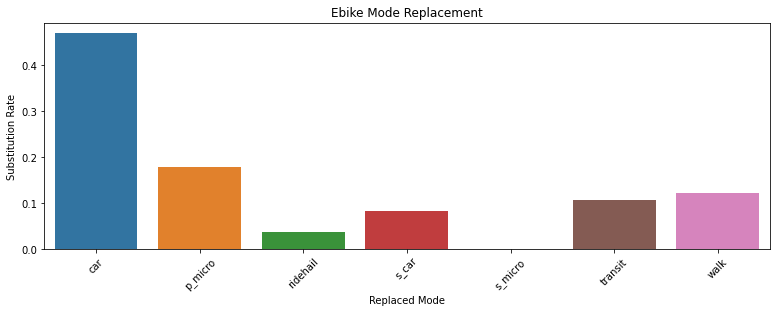

In [45]:
df_analysis = df_ebike.copy()

# Relabel with original mode names for plotting
for mode in av:
    mode_text = '_'.join(str(av[mode]).split('_')[1:])
    df_analysis['Replaced_mode'] = df_analysis['Replaced_mode'].replace(mode,mode_text)
    
# Substitution rate of ebike trips not including new trips
plot_data = df_analysis.groupby(['Replaced_mode']).count()[['Mode_confirm']].reset_index()
plot_data['subst_rate'] = plot_data['Mode_confirm'] / sum(plot_data['Mode_confirm'])

fig, ax = plt.subplots(figsize=(13,5))
sns.barplot(ax=ax, data=plot_data, x='Replaced_mode', y='subst_rate').set(title='Ebike Mode Replacement', xlabel='Replaced Mode', ylabel='Substitution Rate')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)

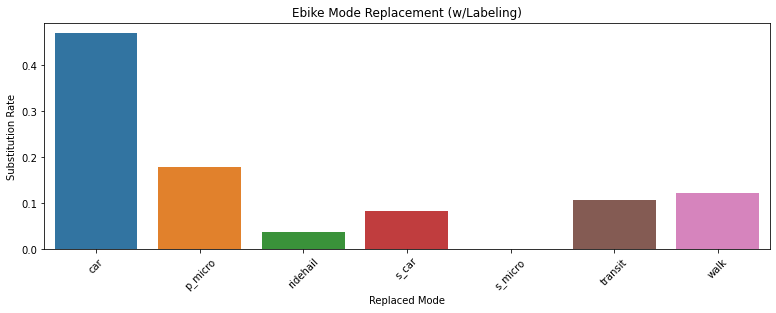

In [46]:
# Now label the replaced mode
y_pred = rf_keep.predict(df_ebike_no_rep[feature_list].values)

for i in range(0, len(y_pred)):
    if df_ebike_no_rep.iloc[i]['Replaced_mode']!=10:
        y_pred[i] = df_ebike_no_rep.iloc[i].Replaced_mode
        
df_ebike_no_rep = df_ebike_no_rep.copy()
df_ebike_no_rep['Replaced_mode_new'] = y_pred

# Generate figure again
# Relabel with original mode names for plotting
for mode in av:
    mode_text = '_'.join(str(av[mode]).split('_')[1:])
    df_ebike_no_rep['Replaced_mode_new'] = df_ebike_no_rep['Replaced_mode_new'].replace(mode,mode_text)
    
# Substitution rate of ebike trips not including new trips
plot_data = df_ebike_no_rep.groupby(['Replaced_mode_new']).count()[['Mode_confirm']].reset_index()
plot_data['subst_rate'] = plot_data['Mode_confirm'] / sum(plot_data['Mode_confirm'])

fig, ax = plt.subplots(figsize=(13,5))
sns.barplot(ax=ax, data=plot_data, x='Replaced_mode_new', y='subst_rate').set(title='Ebike Mode Replacement (w/Labeling)', xlabel='Replaced Mode', ylabel='Substitution Rate')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)

In [47]:
# From table in paper
emission_rates = [343.3, 18.5, 343.3, (343.3/2), 39.8, 123.8, 0.0]
subst_rates = plot_data['subst_rate'].values
subst_rates

array([0.46832579, 0.17951997, 0.03806807, 0.08292347, 0.00118041,
       0.10712178, 0.12286052])

In [48]:
# g-CO2/mi reduction through ebike availability
sum(emission_rates * subst_rates) / sum(subst_rates) - 39.8

164.9086022034232

In [49]:
# New activity
df_ebike_new_trips = data[data['Replaced_mode']==9].copy()
len(df_ebike_new_trips) / len(data)

0.23405671000102365

## Explore Replaced Mode Accuracy

In [50]:
# Look at av column corresponding to stated replaced mode; 1 if available
df_replaced_trips = data[~data['Replaced_mode'].isin([7,8,9,10])].copy()
df_replaced_trips = df_replaced_trips[~data['Replaced_mode'].isin([7,8,9,10])].copy()


replaced_list = [df_replaced_trips[str(av[x])].iloc[i] for i, x in enumerate(df_replaced_trips.Replaced_mode)]
df_replaced_trips['replaced_in_stated'] = replaced_list

# Relabel with original mode names for plotting
for mode in av:
    mode_text = '_'.join(str(av[mode]).split('_')[1:])
    df_replaced_trips['Mode_confirm'] = df_replaced_trips['Mode_confirm'].replace(mode,mode_text)
    df_replaced_trips['Replaced_mode'] = df_replaced_trips['Replaced_mode'].replace(mode,mode_text)

df_replaced_trips['Mode_confirm'] = df_replaced_trips['Mode_confirm'].replace(7,'ebike')
df_replaced_trips['Replaced_mode'] = df_replaced_trips['Replaced_mode'].replace(7,'ebike')

/root/miniconda-4.8.3/envs/emission/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


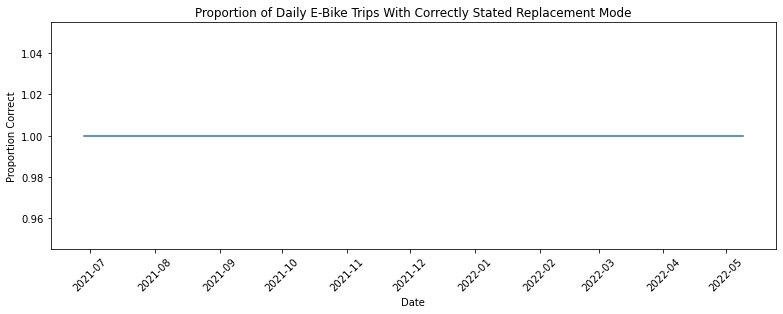

In [51]:
# Accurately stated replacement mode for all users
plot_data = df_replaced_trips[df_replaced_trips['Mode_confirm']=='ebike']
plot_data = plot_data.groupby(['date_time'], as_index=False)['replaced_in_stated'].agg(['sum','count']).apply(lambda x: x.rolling(14,1).mean())
plot_data['proportion'] = plot_data['sum'] / plot_data['count']

fig, ax = plt.subplots(figsize=(13,5))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='proportion').set(title='Proportion of Daily E-Bike Trips With Correctly Stated Replacement Mode', xlabel='Date', ylabel='Proportion Correct')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)

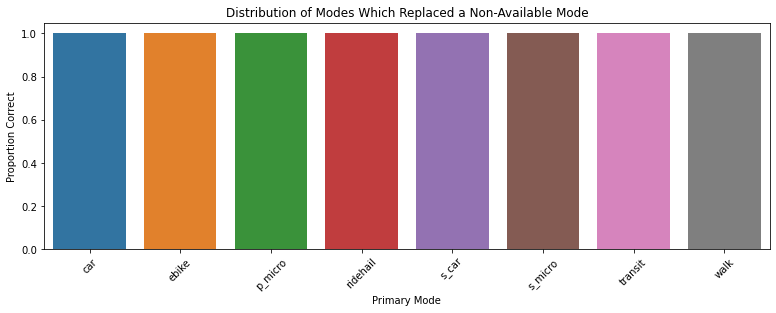

In [52]:
# Accurately stated replacement mode for all users across modes
plot_data = df_replaced_trips.groupby(['Mode_confirm'], as_index=False)['replaced_in_stated'].agg(['sum','count']).reset_index()
plot_data['proportion'] = plot_data['sum'] / plot_data['count']

fig, ax = plt.subplots(figsize=(13,5))
sns.barplot(ax=ax, data=plot_data, x='Mode_confirm', y='proportion').set(title='Distribution of Modes Which Replaced a Non-Available Mode', xlabel='Primary Mode', ylabel='Proportion Correct')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)

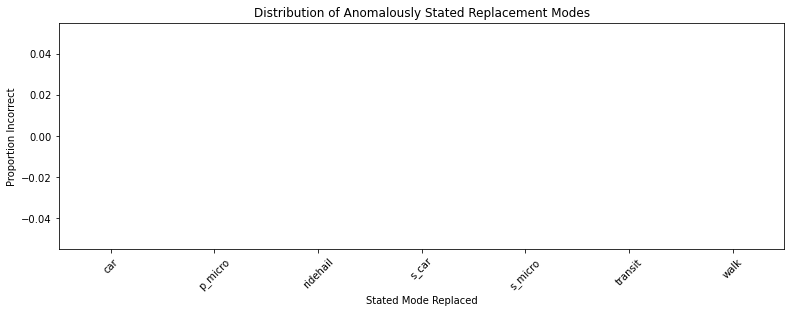

In [53]:
# Accurately stated replacement mode for all users across modes
plot_data = df_replaced_trips.groupby(['Replaced_mode'], as_index=False)['replaced_in_stated'].agg(['sum','count']).reset_index()
plot_data['proportion'] = 1 - (plot_data['sum'] / plot_data['count'])

fig, ax = plt.subplots(figsize=(13,5))
sns.barplot(ax=ax, data=plot_data, x='Replaced_mode', y='proportion').set(title='Distribution of Anomalously Stated Replacement Modes', xlabel='Stated Mode Replaced', ylabel='Proportion Incorrect')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)

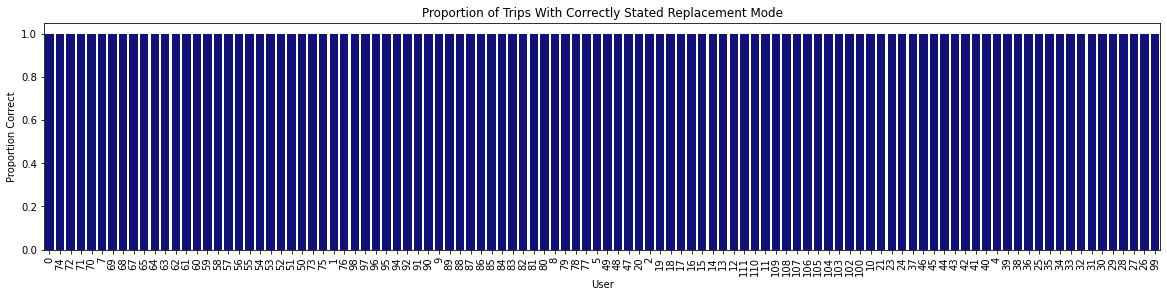

In [54]:
# Accurately stated replacement mode for all users
df_replaced_trips.user_id = df_replaced_trips.user_id.astype(str)
plot_data = df_replaced_trips.groupby(['user_id'], as_index=False)['replaced_in_stated'].agg(['sum','count']).reset_index()
plot_data['proportion'] = plot_data['sum'] / plot_data['count']
plot_data = plot_data.sort_values('proportion', ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(ax=ax, data=plot_data, x='user_id', y='proportion', color='darkblue').set(title='Proportion of Trips With Correctly Stated Replacement Mode', xlabel='User', ylabel='Proportion Correct')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)

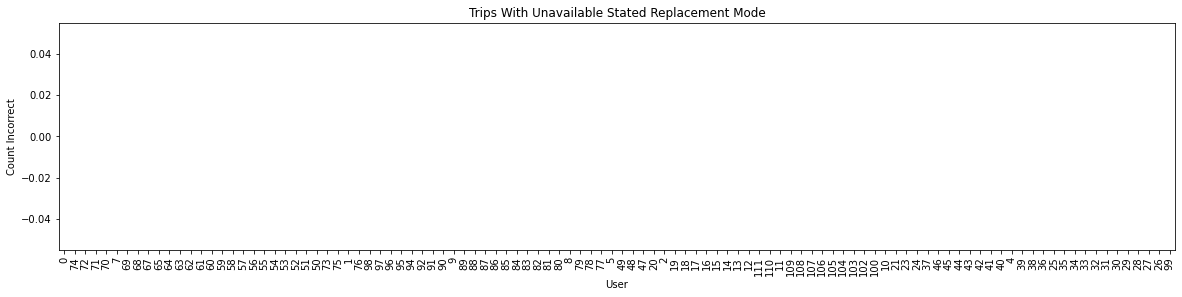

In [55]:
# Accurately stated replacement mode for all users
df_replaced_trips.user_id = df_replaced_trips.user_id.astype(str)
plot_data = df_replaced_trips.groupby(['user_id'], as_index=False)['replaced_in_stated'].agg(['sum','count']).reset_index()
plot_data['incorrect'] = plot_data['count'] - plot_data['sum']
plot_data['user_id'] = plot_data['user_id'].astype(str).str[-4:]
plot_data = plot_data.sort_values('incorrect', ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(ax=ax, data=plot_data, x='user_id', y='incorrect', color='darkblue').set(title='Trips With Unavailable Stated Replacement Mode', xlabel='User', ylabel='Count Incorrect')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)

In [56]:
len(df_replaced_trips) / len(pd.unique(df_replaced_trips.user_id))

259.29245283018867